In [15]:
import pandas as pd
data = pd.read_excel('lab_pre.xlsx')

In [16]:
# Extract relevant columns
research_interests = data['research interests']
lab_descriptions = data['lab description']

# Display the first few entries to verify extraction
research_interests.head(), lab_descriptions.head()

(0    BIOMECHANICS; Ergonomics; Rehabilitation; Ergo...
 1    Geromics; Protein Engineering; Genomics; Bioin...
 2    Cancer genomics; single-cell omics; structural...
 3    3D bioPrinting; tissue engineering; regenerati...
 4    Synthetic Lethality; NA damage recovery; DNA r...
 Name: research interests, dtype: object,
 0    Research at Ergonomics Lab aims at: 1) underst...
 1    Our goal is to develop technologies related to...
 2    We analyze a large number of cancer genomes us...
 3    Bioprinting technology enables the fabrication...
 4    DNA is the building block for the genome and p...
 Name: lab description, dtype: object)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define a function to preprocess text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Join words back to string
    return ' '.join(filtered_tokens)

# Apply the preprocessing function to research interests
preprocessed_interests = research_interests.apply(preprocess_text)

# Display the first few preprocessed entries
preprocessed_interests.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sksms\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sksms\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    biomechanics ergonomics rehabilitation ergonom...
1    geromics protein engineering genomics bioinfor...
2    cancer genomics singlecell omics structural bi...
3    bioprinting tissue engineering regenerative me...
4    synthetic lethality na damage recovery dna rec...
Name: research interests, dtype: object

In [21]:
# Define a simpler preprocessing function without NLTK
def simple_preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Simple tokenization by whitespace
    tokens = text.split()
    # Join words back to string
    return ' '.join(tokens)

# Apply the simpler preprocessing function to research interests
simple_preprocessed_interests = research_interests.apply(simple_preprocess)

# Display the first few preprocessed entries
simple_preprocessed_interests.head()


0    biomechanics ergonomics rehabilitation ergonom...
1    geromics protein engineering genomics bioinfor...
2    cancer genomics singlecell omics structural bi...
3    d bioprinting tissue engineering regenerative ...
4    synthetic lethality na damage recovery dna rec...
Name: research interests, dtype: object

In [22]:
# Check for missing values in 'research interests' and 'lab description'
missing_data_check = {
    "Research Interests Missing Values": research_interests.isnull().sum(),
    "Lab Description Missing Values": lab_descriptions.isnull().sum()
}

missing_data_check


{'Research Interests Missing Values': 0, 'Lab Description Missing Values': 0}

In [23]:
# Remove rows where 'research interests' is missing
cleaned_interests = research_interests.dropna()

# Apply the simple preprocessing function again
cleaned_preprocessed_interests = cleaned_interests.apply(simple_preprocess)

# Display the first few preprocessed entries after cleaning
cleaned_preprocessed_interests.head()


0    biomechanics ergonomics rehabilitation ergonom...
1    geromics protein engineering genomics bioinfor...
2    cancer genomics singlecell omics structural bi...
3    d bioprinting tissue engineering regenerative ...
4    synthetic lethality na damage recovery dna rec...
Name: research interests, dtype: object

In [24]:
# Create a document-word matrix using CountVectorizer
vectorizer = CountVectorizer()
doc_word_matrix = vectorizer.fit_transform(cleaned_preprocessed_interests)

# Define and fit LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(doc_word_matrix)

# Display the topics found by the LDA model
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)


Topic 1:
engineering tissue antenna cancer biomedical devices bio biology molecular disease
Topic 2:
learning deep cancer metabolic protein processor interface architecture bio gene
Topic 3:
system program network learning interaction systems semiconductor computational personalized process
Topic 4:
design system learning security machine systems ai engineering data analysis
Topic 5:
communication engineering soc wireless color theory autonomous disease for power


In [25]:
from sentence_transformers import SentenceTransformer

# Initialize a BERT-based model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocess the lab descriptions using the same simple preprocessing function
preprocessed_descriptions = lab_descriptions.apply(simple_preprocess)

# Compute embeddings for lab descriptions
embeddings = model.encode(preprocessed_descriptions.tolist(), show_progress_bar=True)

# Display the shape of the embeddings to confirm size
embeddings.shape


c:\Users\sksms\anaconda3\envs\fg\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


(93, 384)

In [26]:
from transformers import BertTokenizer, BertModel
import torch

# 모델과 토크나이저 로드
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 텍스트 전처리 및 토큰화
inputs = tokenizer(preprocessed_descriptions.tolist(), padding=True, truncation=True, return_tensors="pt")




In [27]:
# 임베딩 계산
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # 토큰들의 평균을 사용하여 문장 임베딩 생성



In [28]:
# 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings)

In [29]:
similarity_matrix


array([[1.0000005 , 0.8991392 , 0.88976634, ..., 0.8703139 , 0.8732832 ,
        0.823254  ],
       [0.8991392 , 0.99999994, 0.8823072 , ..., 0.85112095, 0.8210488 ,
        0.79286623],
       [0.88976634, 0.8823072 , 1.0000004 , ..., 0.8912662 , 0.89398015,
        0.84928644],
       ...,
       [0.8703139 , 0.85112095, 0.8912662 , ..., 1.0000002 , 0.86046684,
        0.8382839 ],
       [0.8732832 , 0.8210488 , 0.89398015, ..., 0.86046684, 0.9999999 ,
        0.87747127],
       [0.823254  , 0.79286623, 0.84928644, ..., 0.8382839 , 0.87747127,
        1.0000002 ]], dtype=float32)

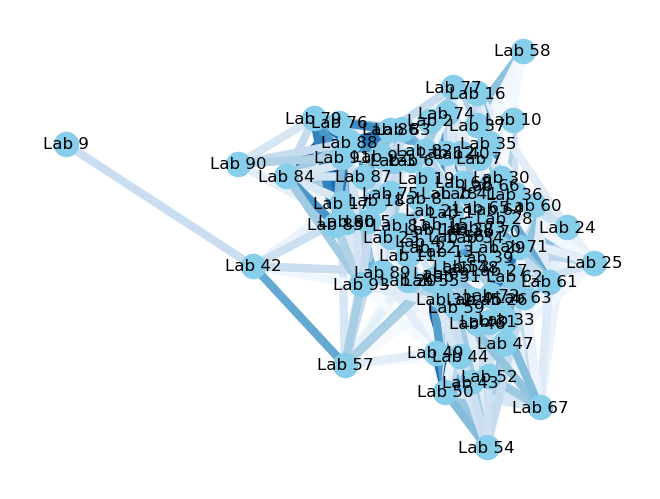

In [30]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 유사도 행렬을 기반으로 그래프 객체 생성
G = nx.Graph()

# 노드 추가 (예: 연구실 이름 또는 번호)
nodes = [f"Lab {i+1}" for i in range(len(similarity_matrix))]
G.add_nodes_from(nodes)

# 엣지 추가 (유사도 임계값 이상인 경우)
threshold = 0.85
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(nodes[i], nodes[j], weight=similarity_matrix[i][j])

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드의 위치를 봄(Spring) 레이아웃 알고리즘을 사용하여 결정
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color=weights, width=6.0, edge_cmap=plt.cm.Blues)
plt.show()


In [51]:
mean_sm = np.mean(similarity_matrix)
mean_sm

0.70109934

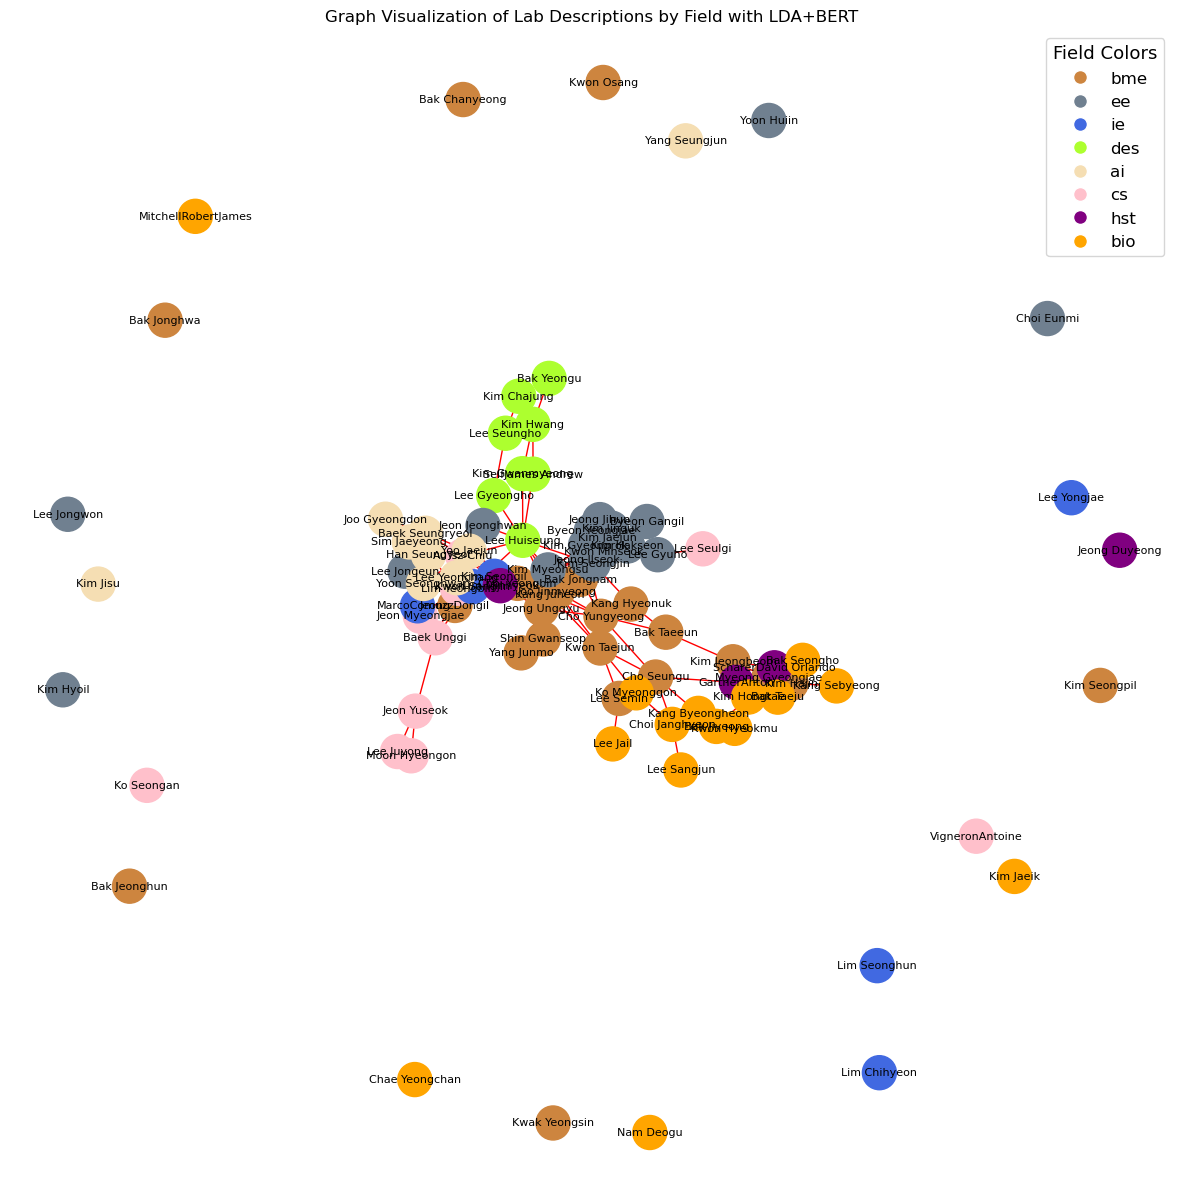

In [68]:
import networkx as nx
import matplotlib.pyplot as plt

titles = data['Title'].tolist()  # Title 열 데이터
fields = data['Field'].tolist()  # Field 열 데이터

# 필드별 색상 딕셔너리
field_colors = {'bme': 'peru', 'ee': 'slategrey', 'ie': 'royalblue', 'des': 'greenyellow', 'ai': 'wheat', 'cs':'pink', 'hst':'purple', 'bio' : 'orange'}

# 그래프 객체 생성
G = nx.Graph()

# 노드 추가
for i, (title, field) in enumerate(zip(titles, fields)):
    node_color = field_colors.get(field, 'gray')  # 필드 정보에 따라 색상을 지정, 기본값은 'gray'
    G.add_node(title, color=node_color)

# 엣지 추가 (유사도 임계값 이상인 경우)
threshold = 0.85
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(titles[i], titles[j], weight=similarity_matrix[i][j])

# 노드의 색상 추출
node_colors = [G.nodes[node]['color'] for node in G]
plt.figure(figsize=(15, 15))

legend_labels = {field: color for field, color in field_colors.items()}
patches = [plt.Line2D([0], [0], marker='o', color='w', label=field,
                      markerfacecolor=color, markersize=10) for field, color in legend_labels.items()]
plt.legend(handles=patches, title="Field Colors", title_fontsize='13', fontsize='12', loc='best')
plt.title('Graph Visualization of Lab Descriptions by Field with LDA+BERT')


# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 결정
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600, edge_color='red', edge_cmap=plt.cm.Blues, font_size=8)
plt.show()


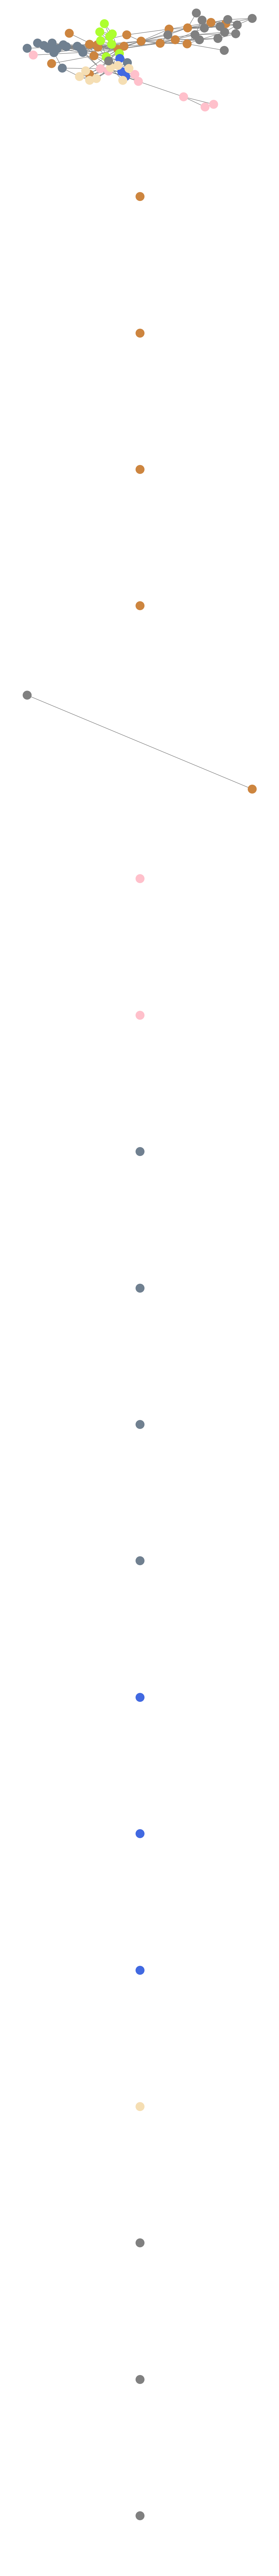

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

# 유사도 행렬과 제목, 필드 데이터
min_val = np.min(similarity_matrix)
max_val = np.max(similarity_matrix)
similarity_matrix = (similarity_matrix - min_val) / (max_val - min_val)



titles = data['Title'].tolist()  # Title 열 데이터
fields = data['Field'].tolist()  # Field 열 데이터

# 필드별 색상 딕셔너리
field_colors = {'bme': 'peru', 'ee': 'slategrey', 'ie': 'royalblue', 'des': 'greenyellow', 'ai': 'wheat', 'cs': 'pink'}

# 그래프 객체 생성
G = nx.Graph()

# 노드 추가
for i, (title, field) in enumerate(zip(titles, fields)):
    node_color = field_colors.get(field, 'gray')  # 필드 정보에 따라 색상을 지정, 기본값은 'gray'
    G.add_node(title, color=node_color)

# 엣지 추가 (유사도 임계값 이상인 경우)
threshold = 0.84
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(titles[i], titles[j], weight=similarity_matrix[i][j])

# 연결된 컴포넌트 식별
connected_components = list(nx.connected_components(G))

# 범례 추가
legend_labels = {field: color for field, color in field_colors.items()}
patches = [plt.Line2D([0], [0], marker='o', color='w', label=field,
                      markerfacecolor=color, markersize=10) for field, color in legend_labels.items()]


# 하위 그래프 시각화
fig, axes = plt.subplots(nrows=len(connected_components), figsize=(10, len(connected_components) * 5))

if len(connected_components) == 1:
    axes = [axes]  # 하나의 컴포넌트만 있을 때도 axes를 리스트로 처리

for ax, component in zip(axes, connected_components):
    subgraph = G.subgraph(component)
    node_colors = [subgraph.nodes[node]['color'] for node in subgraph]
    pos = nx.spring_layout(subgraph)  # 하위 그래프의 노드 위치 결정
    nx.draw(subgraph, pos, ax=ax, with_labels=False, node_color=node_colors, node_size=300, edge_color='gray', edge_cmap=plt.cm.Blues, font_size=8)

plt.show()


In [78]:
similarity_matrix

array([[1.        , 0.8076205 , 0.78974307, ..., 0.75209963, 0.74066955,
        0.6801363 ],
       [0.8076205 , 0.999999  , 0.77551574, ..., 0.6490695 , 0.668187  ,
        0.6243121 ],
       [0.78974307, 0.77551574, 1.        , ..., 0.6611168 , 0.681798  ,
        0.712081  ],
       ...,
       [0.75209963, 0.6490695 , 0.6611168 , ..., 0.9999984 , 0.8557309 ,
        0.6679898 ],
       [0.74066955, 0.668187  , 0.681798  , ..., 0.8557309 , 0.99999934,
        0.753135  ],
       [0.6801363 , 0.6243121 , 0.712081  , ..., 0.6679898 , 0.753135  ,
        0.9999991 ]], dtype=float32)